# Detecting Fraudulent Financial Transactions

The purpose of this analysis is to initially explore the data to identify variables that correlate with fraudulent transactions, cleanse the data, and exclude any data we deem to be irrelevant.

This cleansed dataset will then be fed into our machine learning model to developer a generalized model for fraud detection.

NB: At first glance, this data looks to be be heavily skewed towards fraudulent orders hidden within repeat customer orders, so the eventual model will be better suited to identifying repeat order fraud, and much less so first order fraud.
    - This is based on the understanding that `step` is the x order placed by a customer for a merchant, but this may be incorrect.

In [2]:
import pandas as pd
from util.data_access import load_data

pd.set_option('display.expand_frame_repr', False)

df = load_data()
print("Length of dataset:", len(df))

df.head

Length of dataset: 594643


<bound method NDFrame.head of         step       customer  age gender zipcodeOri       merchant zipMerchant             category  amount  fraud
0          0  'C1093826151'  '4'    'M'    '28007'   'M348934600'     '28007'  'es_transportation'    4.55      0
1          0   'C352968107'  '2'    'M'    '28007'   'M348934600'     '28007'  'es_transportation'   39.68      0
2          0  'C2054744914'  '4'    'F'    '28007'  'M1823072687'     '28007'  'es_transportation'   26.89      0
3          0  'C1760612790'  '3'    'M'    '28007'   'M348934600'     '28007'  'es_transportation'   17.25      0
4          0   'C757503768'  '5'    'M'    '28007'   'M348934600'     '28007'  'es_transportation'   35.72      0
...      ...            ...  ...    ...        ...            ...         ...                  ...     ...    ...
594638   179  'C1753498738'  '3'    'F'    '28007'  'M1823072687'     '28007'  'es_transportation'   20.53      0
594639   179   'C650108285'  '4'    'F'    '28007'  'M1823

# Initial Comments
based on the Pandas profiling report

## Data Cleansing
- Some orders have an order amount of 0. None of these orders are fraudulent, so I believe it's safe to remove these orders.
- zipMerchant and zipCodeOri are both constant, providing no value. These columns can be removed.

## Data Patterns
- Average number of orders placed per customer is 95.
- Only 4000 customers with 594643 orders, meaning our dataset is highly skewed towards repeat order fraud detection. This is due to the nature our dataset is synthetic.
- Gender is highly correlated with age. This skews our model as there should be no significant correlation between gender and age.
- Only 50 merchants, and merchant is highly correlated with fraud.
- Data is extremely skewed towards the `es_transportation` category (85% of all orders). 

- Age
    - 0: <=18
    - 1: 19-25
    - 2: 26-35
    - 3: 36-45
    - 4: 46-55
    - 5: 56-65
    - 6: >65
    - U: Unknown

- Gender
    - E: Enterprise
    - F: Female
    - M: Male
    - U: Unkown

In [ ]:
print("Length of 0 amount orders:", len(df.query('amount == 0')))
assert len(df.query('amount == 0 and fraud == 1')) == 0

# Drop 0 amount orders
df = df.loc[df['amount'] != 0]
print(len(df))

# Drop constant columns
df = df.drop(columns=['zipcodeOri', 'zipMerchant'])

df.head




In [ ]:
assert len(df.query('category.str.contains("es_transportation") and fraud == 1')) == 0

# Absolutely no fraudulent transactions were in category es_transportation with 85% of all orders.
# Grouping fraudulent transactions based on category

# Percentage of fraudulent orders
df.groupby(by=["category"])['fraud'].value_counts(normalize=True)



## Fraud Percentages by Category

1. `es_leisure`: 95%
2. `es_travel`: 79%
3. `es_sportsandtoys`: 50%
4. `es_hotelservices`: 31%
5. `es_otherservices`: 25%
6. `es_home`: 15%
7. `es_health`: 11%
8. `es_tech`: 7%
9. `es_wellnessandbeauty`: 5%
10. `es_hyper`: 5%
11. `es_barsandrestaurants`: 2%
12. `es_fashion`: 2%
13: `es_contents`, `es_food`, `es_transportation`: 0%

In [ ]:
merchant_grouping = df.groupby('merchant')['fraud'].value_counts(normalize=True).rename('proportion').reset_index(level=1)
merchant_grouping[merchant_grouping['fraud'] == 1].sort_values('proportion',ascending=False) 

## Highest Fraud Rates per Merchant
- 'M1294758098': 0.963351
- 'M3697346': 0.941558
- 'M1873032707': 0.864000
- 'M732195782': 0.851974
- 'M980657600': 0.832109
- 'M1353266412': 0.820513
- 'M857378720': 0.754098
- 'M2080407379': 0.750000
- 'M2011752106': 0.680328
- 'M17379832': 0.631206
- 'M2122776122': 0.586510

Interesting note: Only 30 merchants had fraudulent transactions placed. Really low number.

In [ ]:
customer_grouping = df.groupby('customer')['fraud'].value_counts(normalize=True).rename('proportion').reset_index(level=1)
customer_grouping[customer_grouping['fraud'] == 1].sort_values('proportion',ascending=False).query('proportion > 0.5')

# Potentially some more complex analysis here to understand the percentiles (how many customers commit fraud 90-100% of the time, 80-90% etc)

# Highest Fraud Rates per Customer
- 'C910454738': 0.945652
- 'C2004941826': 0.944444
- 'C381007057': 0.890000
- 'C1572610482': 0.881188
- 'C617723960': 0.869565
- 'C2113737065': 0.868132
- 'C2060410910': 0.846154
- 'C483912131': 0.816327
- 'C1809646275': 0.800000
- 'C1817318774': 0.776786
- 'C1350963410': 0.753927
- 'C1849046345': 0.742690
- 'C1175850429': 0.725664
- 'C371517012': 0.720000
- 'C1233811793': 0.714286
- 'C1454826238': 0.700000
- 'C126638730': 0.681818
- 'C611182051': 0.671642
- 'C1803182614': 0.666667
- 'C231476583': 0.640000
- 'C1464489812': 0.634783
- 'C932908444': 0.632353
- 'C1237248073': 0.629630
- 'C650117238': 0.625000
- 'C245117318': 0.620370
- 'C1685492470': 0.606742
- 'C1562081159': 0.600000
- 'C1338125837': 0.552632
- 'C204205576': 0.550000
- 'C616715154': 0.547619
- 'C751887992': 0.541667
- 'C1560904250': 0.538462
- 'C1994178184': 0.537736
- 'C806399525': 0.527426
- 'C1163388474': 0.526316
- 'C894204131': 0.523810
- 'C1653588482': 0.517857

## How Many Transactions are Customers Making?
By grouping the data on the customer, we observe the following:
- Customers can make anywhere from 5 to 265 Transactions over the 180 Steps
- Most customers lie within the range of 150-180 transactions (i.e. are making a transaction/day)
- There is a sharp dropoff after 180 transactions, with only 3% of customers having more than 180 Transactions

Feature Possibilities:
- Average Value of Previous Transactions
- Number of Previous Transactions
- Has Been Fraudulent in a Previous Transaction

Unique Transactions by Customer Overview
--------------
count    4112.000000
mean      144.611625
std        42.788212
min         5.000000
25%       130.000000
50%       165.000000
75%       173.000000
max       265.000000
Name: fraud, dtype: float64
--------------
Proportion of Customers with >180 Transactions: 0.03


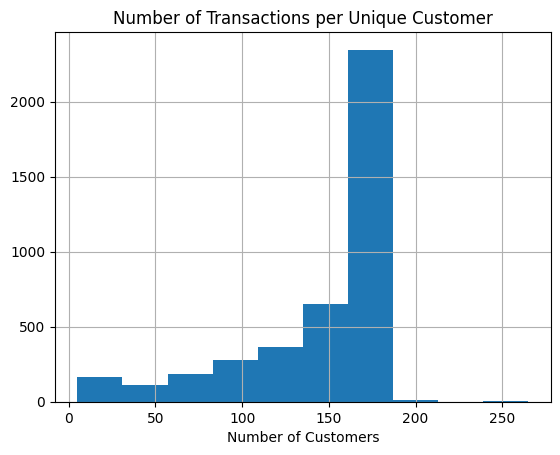

In [20]:
import matplotlib.pyplot as plt
unique_transactions_by_customer = df.groupby('customer').count()['fraud'].sort_values()
print('Unique Transactions by Customer Overview')
print('--------------')
print(unique_transactions_by_customer.describe())
print('--------------')
print(f'Proportion of Customers with >180 Transactions: {unique_transactions_by_customer[unique_transactions_by_customer > 180].count() / unique_transactions_by_customer.count():.2f}')


ax = unique_transactions_by_customer.hist()
ax.set_xlabel('Number of Transactions')
ax.set_xlabel('Number of Customers')
ax.set_title('Number of Transactions per Unique Customer')
ax.plot();